# **Import des librairies**

In [ ]:
from __future__ import print_function 
from __future__ import division  
import numpy as np
import pandas as pd
import math
from statistics import mean 
import matplotlib.pyplot as plt
import os
import cv2 as cv 
import sys
from PIL import Image
from numpy import asarray
#from skimage.measure import structural_similarity as ssim
from skimage import measure
from skimage.metrics import structural_similarity as ssim
import time
import tarfile
import xml.dom.minidom as md
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
from skimage.color import rgb2gray
import skimage as ski # Scikit-Image : Image processing
import skimage.feature
import skimage.morphology
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import img_as_float
from skimage.util import img_as_ubyte
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from google.colab import drive
#!pip install patool
from scipy.stats import multivariate_normal as mvn
from imutils import contours
from collections import Counter
from tqdm import tqdm

In [ ]:
#liaison  avec le drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Chargement des Images**

In [ ]:
file = "/content/drive/MyDrive/Images"
os.chdir(file)
dossier = os.listdir()

In [ ]:
dossier

['GT', 'ROI', 'img_Qui_1.png', 'img_Qui_2.png', 'img_Qui_3.png']

## **Images ROI**

In [ ]:
#sélection du dossier ROI et son contenu
dossier = "ROI"
res = os.listdir(dossier)
res.sort()
res

['ROI_Lydia', 'ROI_Melen', 'ROI_Stef']

In [ ]:
#récupération des noms des images pour chaque fichier
ROI = [os.listdir(dossier+"/"+folder) for folder in res if folder != '.DS_Store']

#chaque item correspond à une liste d'images pour les 3 dossiers, 
#on les range dans l'ordre pour garder le même ordre avec GT
ROI[0].sort()
ROI[1].sort()
ROI[2].sort()

#rajout des racines
folder = os.listdir(dossier)
if '.DS_Store' in folder:
  folder.remove('.DS_Store')
folder.sort()

#scinder les adresses+noms photos en un seul vecteur
ROI = [dossier + "/" + folder[0] + "/" + i for i in ROI[0]]+ [dossier + "/" + folder[1] + "/"+ i for i in ROI[1]] + [dossier + "/" + folder[2] + "/" + i for i in ROI[2]]

#on garde que les jpg
ROI = [i for i in ROI if i[len(i)-4:len(i)]==".jpg"]
len(ROI)

405

## **Images GT**

In [ ]:
dossier = "GT"
res = os.listdir(dossier)
res.sort()
res

['GT_2021_Lydia', 'GT_2021_Melen', 'GT_2021_Stef']

In [ ]:
GT = [os.listdir(dossier+"/"+folder) for folder in res if folder != '.DS_Store']
GT[0].sort()
GT[1].sort()
GT[2].sort()

#rajout des racines
folder = os.listdir(dossier)
if '.DS_Store' in folder:
  folder.remove('.DS_Store')
folder.sort()

GT = [dossier + "/" + folder[0] + "/" + i for i in GT[0]]+ [dossier + "/" + folder[1] + "/" + i for i in GT[1]] + [dossier + "/" + folder[2] + "/" + i for i in GT[2]]

GT = [i for i in GT if i[len(i)-4:len(i)]==".png"]
len(GT)

405

## **Zoom et réduction des dimensions de la feuille**

In [ ]:
def zoom_ROI(img):
    ## (1) Convert to gray, and threshold
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, threshed = cv.threshold(gray, 240, 255, cv.THRESH_BINARY_INV)

    ## (2) Morph-op to remove noise
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11,11))
    morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

    ## (3) Find the max-area contour
    cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv.contourArea)[-1]

    ## (4) Crop and return it
    x,y,w,h = cv.boundingRect(cnt)
    dst = img[y:y+h, x:x+w]
    return(dst)

def reduire(img, shape1=600, shape2=400):
  dst = img_as_ubyte(resize(img, (shape1, shape2)))
  dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
  return(dst)

def reduire2(img, div=4):
  dst = resize(img, (np.floor(img.shape[0]/div), np.floor(img.shape[1]/div)),4, preserve_range=True)
  return(dst)

In [ ]:
def img_to_label(img_true,RGB=False):
  img = np.copy(img_true)

  img_lbl = np.zeros((img_true.shape[0],img_true.shape[1]))

  #white to lbl
  lower_white = np.array([240,240,240], dtype = "uint16")
  upper_white = np.array([255,255,255], dtype = "uint16")
  black_mask_white = cv.inRange(img, lower_white, upper_white)
  #green to lbl
  lower_green = np.array([0,230,80], dtype = "uint16")
  upper_green = np.array([20, 255, 120], dtype = "uint16")
  black_mask_green = cv.inRange(img, lower_green, upper_green)
  #blue to lbl
  lower_blue = np.array([0,0,80], dtype = "uint16")
  upper_blue = np.array([20, 120, 255], dtype = "uint16")
  black_mask_blue= cv.inRange(img, lower_blue, upper_blue)

  if RGB:
    img[np.where(black_mask_white == [255])] = [255,255,255]
    img[np.where(black_mask_green == [255])] = [0,255,0]
    img[np.where(black_mask_blue == [255])] = [0,0,255]
    return img
  else:
    img_lbl[np.where(black_mask_green == [255])] = [0]
    img_lbl[np.where(black_mask_white == [255])] = [1]
    img_lbl[np.where(black_mask_blue == [255])] = [2]
    return img_lbl

In [ ]:
images_GT = []
for nomFichier in tqdm(GT):
  images_GT.append(reduire(zoom_ROI(io.imread(nomFichier))))
print("done")

100%|██████████| 405/405 [08:06<00:00,  1.20s/it]

done


In [ ]:
images_ROI = []
for nomFichier in tqdm(ROI):
  images_ROI.append(reduire(zoom_ROI(io.imread(nomFichier))))
print("done")

100%|██████████| 405/405 [06:38<00:00,  1.02it/s]

done


In [ ]:
def gmm_tamo(_img1, path1):
  ''' _img1 est l'image à 13dpi, _img2 à 11dpi et _img3 à 07dpi
      path1 est le chemin de _img1, path2 celui de _img2 et path3 celui de _img3
  '''

  path2 = path1.replace('13dpi', '11dpi')
  path3 = path1.replace('13dpi', '07dpi')
  _img2 = reduire(zoom_ROI(io.imread(path2)))
  _img3 = reduire(zoom_ROI(io.imread(path3)))

  gmm = GaussianMixture(n_components = 3, covariance_type = "tied", tol = 1e-3)
  gmm_img = gmm.fit(_img1.reshape(_img1.shape[0]*_img1.shape[1],3))
  kernel1 = np.ones((15,15), dtype='uint8')
  kernel2 = np.ones((10,8), dtype='uint8')
  kernel3 = np.ones((5,5), dtype='uint8')


  cluster_img1 = gmm_img.predict(_img1.reshape(_img1.shape[0]*_img1.shape[1],3))
  cluster_img1 = cluster_img1.reshape(_img1.shape[0], _img1.shape[1])
  img_closed_1 = cv.morphologyEx(np.uint8(cluster_img1), cv.MORPH_CLOSE, kernel1)
  label_count_1 = Counter(cluster_img1.reshape(-1))
  label_count_1 = sorted(label_count_1.values())
  prop_1 = label_count_1[0]/(label_count_1[0] + label_count_1[1])

  cluster_img2 = gmm_img.predict(_img2.reshape(_img2.shape[0]*_img2.shape[1],3))
  cluster_img2 = cluster_img2.reshape(_img2.shape[0], _img2.shape[1])
  img_closed_2 = cv.morphologyEx(np.uint8(cluster_img2), cv.MORPH_CLOSE, kernel2)
  label_count_2 = Counter(cluster_img2.reshape(-1))
  label_count_2 = sorted(label_count_2.values())
  prop_2 = label_count_2[0]/(label_count_2[0] + label_count_2[1])

  cluster_img3 = gmm_img.predict(_img3.reshape(_img3.shape[0]*_img3.shape[1],3))
  cluster_img3 = cluster_img3.reshape(_img3.shape[0], _img3.shape[1])
  img_closed_3 = cv.morphologyEx(np.uint8(cluster_img3), cv.MORPH_CLOSE, kernel3)
  label_count_3 = Counter(cluster_img3.reshape(-1))
  label_count_3 = sorted(label_count_3.values())
  prop_3 = label_count_3[0]/(label_count_3[0] + label_count_3[1])

  return prop_1, prop_2, prop_3, img_closed_1, img_closed_2, img_closed_3, cluster_img1, cluster_img2, cluster_img3

In [ ]:
pct = []
name = []
closed_imgs = []
cluster_imgs = []

for i in tqdm(range(len(ROI))):
  if '13dpi' in ROI[i]:
    img_ROI = reduire(zoom_ROI(io.imread(ROI[i])))
    GMM = gmm_tamo(img_ROI, ROI[i])

    # construction de la base
    path1 = ROI[i]
    path2 = ROI[i].replace('13dpi', '11dpi')
    path3 = ROI[i].replace('13dpi', '07dpi')
    
    pct.append(GMM[2])
    name.append(path3)
    closed_imgs.append(GMM[5])
    cluster_imgs.append(GMM[8])

    pct.append(GMM[1])
    name.append(path2)
    closed_imgs.append(GMM[4])
    cluster_imgs.append(GMM[7])

    pct.append(GMM[0])
    name.append(path1)
    closed_imgs.append(GMM[3])
    cluster_imgs.append(GMM[6])

  6%|▌         | 24/405 [01:10<17:39,  2.78s/it]/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 75%|███████▍  | 303/405 [13:54<04:58,  2.92s/it]/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
100%|██████████| 405/405 [18:56<00:00,  2.81s/it]


In [ ]:
eps = []
for i in range(len(closed_imgs)):
  y_actu = pd.Series(img_to_label(images_GT[i]).ravel(), name='Actual')
  y_pred = pd.Series(closed_imgs[i].ravel(), name='Predicted')
  eps.append(accuracy_score(y_actu, y_pred))

mean(eps)

0.5467043518518518

## **Images nécessitant une attention particulière**

Certaines images nécessitent une reparamétrisation de la méthode afin d'avoir une bonne segmentation, grâce aux vérités terrain, nous pouvons directement comparer les prédictions à la réalité. Nous allons donc relancer l'algorithme sur les images dont la précision est inférieure à 50%

In [ ]:
ind = np.asarray(np.where(np.array(eps)<0.5))
ind

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  17,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  39,  40,  41,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  60,  61,  62,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  81,  82,  83,  84,  85,  87,
         96,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        117, 118, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 135,
        136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149,
        151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 165, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182,
        184, 185, 189, 190, 191, 192, 193, 194, 195, 196, 197, 201, 202,
        203, 204, 205, 206, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 234,
        235, 236, 237, 243, 244, 245, 246, 247, 248

In [ ]:
def gmm_img(img):

  gmm = BayesianGaussianMixture(n_components = 3, covariance_type = "tied", tol = 1e-5)
  gmm_img = gmm.fit(img.reshape(img.shape[0]*img.shape[1],3))
  kernel = np.ones((10,5), dtype='uint8')


  cluster_img = gmm_img.predict(img.reshape(img.shape[0]*img.shape[1],3))
  cluster_img = cluster_img.reshape(img.shape[0], img.shape[1])
  img_closed = cv.morphologyEx(np.uint8(cluster_img), cv.MORPH_CLOSE, kernel)
  label_count = Counter(img_closed.reshape(-1))
  label_count = sorted(label_count.values())
  prop = label_count[0]/(label_count[0] + label_count[1])
  return prop, cluster_img, img_closed

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


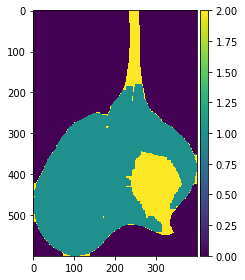

In [ ]:
imshow(closed_imgs[2])

In [ ]:
p, ci, ic = gmm_img(reduire(zoom_ROI(io.imread(ROI[2]))))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


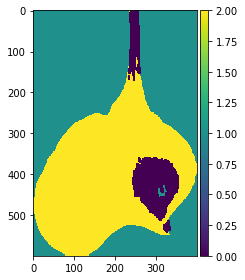

In [ ]:
imshow(ic)

In [ ]:
for i in tqdm(range(len(ind[0]))):
  img_ROI = reduire(zoom_ROI(io.imread(ROI[ind[0][i]])))
  G = gmm_img(img_ROI)
  cluster_imgs[ind[0][i]] = G[1]
  closed_imgs[ind[0][i]] = G[2]
  pct[ind[0][i]] = G[0]

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
100%|██████████| 280/280 [46:31<00:00,  9.97s/it]


Après cette étape, les images aux index ci-dessous ont encore une mauvaise segmentation (inacceptable). On va augmenter la précision et changer la matrice de covariance des classes

In [ ]:
ind = np.asarray(np.where(np.array(eps)<0.85))
ind

array([[  0,   3,   4,   7,   8,  13,  25,  42,  59,  76,  82,  84,  89,
         95,  97, 119, 121, 128, 136, 139, 140, 143, 145, 163, 164, 165,
        166, 167, 172, 173, 179, 187, 188, 189, 201, 210, 217, 219, 220,
        225, 226, 227, 228, 232, 239, 240, 243, 267, 271, 282, 300, 302,
        304, 305, 311, 315, 322, 323, 326, 338, 342, 343, 344, 346, 347,
        358, 359, 362, 364, 368, 371, 381, 393]])

**NB : Reprendre les étapes précédentes jusqu'à ce que la précision globale n'augmente plus**

In [ ]:
def gmm_img2(img):

  gmm = GaussianMixture(n_components = 3, covariance_type = "tied", tol = 1e-10)
  gmm_img = gmm.fit(img.reshape(img.shape[0]*img.shape[1],3))
  kernel = np.ones((5,5), dtype='uint8')


  cluster_img = gmm_img.predict(img.reshape(img.shape[0]*img.shape[1],3))
  cluster_img = cluster_img.reshape(img.shape[0], img.shape[1])
  img_closed = cv.morphologyEx(np.uint8(cluster_img), cv.MORPH_CLOSE, kernel)
  label_count = Counter(img_closed.reshape(-1))
  label_count = sorted(label_count.values())
  prop = label_count[0]/(label_count[0] + label_count[1])
  return prop, cluster_img, img_closed

In [ ]:
for i in tqdm(range(len(ind[0]))):
  img_ROI = reduire(zoom_ROI(io.imread(ROI[ind[0][i]])))
  G = gmm_img2(img_ROI)
  cluster_imgs[ind[0][i]] = G[1]
  closed_imgs[ind[0][i]] = G[2]
  pct[ind[0][i]] = G[0]

 50%|█████     | 10/20 [01:29<01:15,  7.54s/it]/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
 55%|█████▌    | 11/20 [01:47<01:35, 10.59s/it]/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
100%|██████████| 20/20 [03:07<00:00,  9.40s/it]


In [ ]:
eps = []
for i in range(len(closed_imgs)):
  y_actu = pd.Series(img_to_label(images_GT[i]).ravel(), name='Actual')
  y_pred = pd.Series(closed_imgs[i].ravel(), name='Predicted')
  eps.append(accuracy_score(y_actu, y_pred))

mean(eps)

0.8886544958847736

In [ ]:
def pixel_sain_necrose_clust(cluster):
  """
  cluster correspond à l'image segmentée
  """
  label = cluster.ravel()
  df = pd.DataFrame(label, columns =["label"])
  res = df["label"].value_counts()
  df = pd.DataFrame(res).transpose()
  return(df)

In [ ]:
df1 = pd.DataFrame()
for i in tqdm(range(len(GT))):
  clust_i = cluster_imgs[i]
  df_new = pixel_sain_necrose_clust(clust_i)
  df1 = pd.concat([df1, df_new])

df1.head()

100%|██████████| 405/405 [00:01<00:00, 224.19it/s]


,0,1,2
label,82161,125121,32718
label,101489,117873,20638
label,92968,128447,18585
label,74005,102280,63715
label,109985,83450,46565


In [ ]:
df_GMM = pd.DataFrame({'nom':name,
                   'surface':pct})

In [ ]:
df_GMM.head()

,fond,feuille,necrose,surface
label,82161,125121,32718,0.018217
label,101489,117873,20638,0.039298
label,92968,128447,18585,0.110046
label,74005,102280,63715,0.000138
label,109985,83450,46565,0.007884


In [ ]:
df.to_csv(index=False)

'0,1,2\n125047.0,2302.0,112651\n124139.0,45359.0,70502\n127511.0,83251.0,29238\n137487.0,102474.0,39\n128772.0,109916.0,1312\n111733.0,112781.0,15486\n115773.0,118529.0,5698\n97485.0,130710.0,11805\n81853.0,135138.0,23009\n85324.0,97835.0,56841\n11203.0,109605.0,119192\n3465.0,111185.0,125350\n107083.0,89330.0,43587\n107558.0,55001.0,77441\n105355.0,6971.0,127674\n101270.0,173.0,138557\n100873.0,19505.0,119622\n97522.0,125946.0,16532\n104744.0,810.0,134446\n110620.0,14002.0,115378\n109501.0,106907.0,23592\n74.0,92399.0,147527\n1582.0,94588.0,143830\n2214.0,94509.0,143277\n106693.0,84.0,133223\n107897.0,88.0,132015\n108355.0,73787.0,57858\n189347.0,50148.0,505\n191186.0,47096.0,1718\n184873.0,48499.0,6628\n96030.0,361.0,143609\n95666.0,6138.0,138196\n93990.0,18490.0,127520\n144067.0,95682.0,251\n139807.0,93881.0,6312\n128991.0,94757.0,16252\n143232.0,96548.0,220\n132114.0,103016.0,4870\n128270.0,100956.0,10774\n91286.0,35778.0,112936\n98222.0,85949.0,55829\n121119.0,106952.0,11929\n1211

## **Comparaison aux images GT**

In [ ]:
def pixel_sain_necrose_GT(GT):
  """
  GT correspond à l'adresse d'une image GT
  """

  imgGT = reduire(zoom_ROI(io.imread(GT)))
  label = img_to_label(imgGT).ravel()
  df = pd.DataFrame(label, columns =["label"])
  res = df["label"].value_counts()
  df = pd.DataFrame(res).transpose().rename(index={'label' : GT.split("/")[2].split('.')[0]})
  return(df)

In [ ]:
df2 = pd.DataFrame()
for i in tqdm(range(len(GT))):
  GT_i = GT[i]
  df_new = pixel_sain_necrose_GT(GT_i)
  df2 = pd.concat([df2, df_new])

df2.head()

100%|██████████| 405/405 [06:24<00:00,  1.05it/s]


,0.0,1.0,2.0
A30_18W34_p1c1_07dpi,116128,123872,NaN
A30_18W34_p1c1_11dpi,112101,122856,5043.0
A30_18W34_p1c1_13dpi,99308,127139,13553.0
A30_18W40_p2c1_07dpi,138988,100947,65.0
A30_18W40_p2c1_11dpi,127964,108630,3406.0


In [ ]:
df2.to_csv(index=False)

'0.0,1.0,2.0\n116128,123872,\n112101,122856,5043.0\n99308,127139,13553.0\n138988,100947,65.0\n127964,108630,3406.0\n114189,110748,15063.0\n123530,116431,39.0\n106460,128792,4748.0\n96349,132785,10866.0\n145214,94727,59.0\n132254,104056,3690.0\n123641,107563,8796.0\n134031,105889,80.0\n133191,106346,463.0\n131680,104952,3368.0\n139797,100153,50.0\n139686,100082,232.0\n140923,97625,1452.0\n135953,103677,370.0\n129578,109717,705.0\n129486,109567,947.0\n148675,91172,153.0\n144280,93457,2263.0\n144060,93679,2261.0\n134479,105425,96.0\n132936,106914,150.0\n132013,107805,182.0\n191224,48435,341.0\n192771,46150,1079.0\n188764,47155,4081.0\n144919,94696,385.0\n138157,94826,7017.0\n123822,93688,22490.0\n145557,94263,180.0\n141766,92603,5631.0\n133281,93774,12945.0\n144716,95079,205.0\n133575,101619,4806.0\n131397,99431,9172.0\n149660,90156,184.0\n134445,97513,8042.0\n116359,120828,2813.0\n119788,120112,100.0\n117394,121006,1600.0\n110631,123542,5827.0\n156689,83251,60.0\n150982,83330,5688.0\n144

In [ ]:
df2.fillna(0,inplace=True)
df_GT = pd.DataFrame({'fond' :df2[1], 'feuille' : df2[0], 'necrose' : df2[2], 'surface' : df2[2]/(df2[0]+df2[2])})
df_GT.head()

,fond,feuille,necrose,surface
A30_18W34_p1c1_07dpi,123872,116128,0.0,0.000000
A30_18W34_p1c1_11dpi,122856,112101,5043.0,0.043050
A30_18W34_p1c1_13dpi,127139,99308,13553.0,0.120086
A30_18W40_p2c1_07dpi,100947,138988,65.0,0.000467
A30_18W40_p2c1_11dpi,108630,127964,3406.0,0.025927


In [ ]:
df_GMM.head()

,fond,time,feuille,necrose,surface
label,82161,07dpi,125121,32718,0.018217
label,101489,11dpi,117873,20638,0.039298
label,92968,13dpi,128447,18585,0.110046
label,74005,07dpi,102280,63715,0.000138
label,109985,11dpi,83450,46565,0.007884


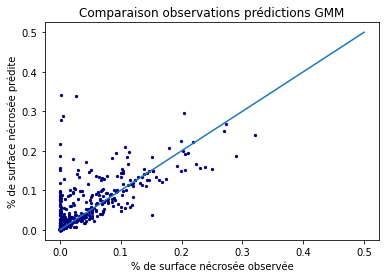

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(df_GT['surface'], df_GMM['surface'], s=5, c='navy')
plt.plot([0.0, 0.5], [0, 0.5])
plt.xlabel("% de surface nécrosée observée")
plt.ylabel("% de surface nécrosée prédite")
plt.title('Comparaison observations prédictions GMM')
plt.savefig('comp_Gmm.png')

In [ ]:
df_GT.pop('time')
df_GT.insert(1, 'time', np.asarray(df_1['time']), allow_duplicates=False)

In [ ]:
df_GMM.pop('time')
df_GMM.insert(1, 'time', np.asarray(df_1['time']), allow_duplicates=False)

In [ ]:
df_GT[df_GT['time']=='13dpi']

,fond,time,feuille,necrose,surface
A30_18W34_p1c1_13dpi,127139,13dpi,99308,13553.0,0.120086
A30_18W40_p2c1_13dpi,110748,13dpi,114189,15063.0,0.116540
A30_OzB12_p1c2_13dpi,132785,13dpi,96349,10866.0,0.101348
A30_OzB24_p1c1_13dpi,107563,13dpi,123641,8796.0,0.066416
Bon_18W34_p1c1_13dpi,104952,13dpi,131680,3368.0,0.024939
...,...,...,...,...,...
Wes_18W34_p2c2_13dpi,104266,13dpi,125416,10318.0,0.076016
Wes_OzB24_p2c1_13dpi,97012,13dpi,140708,2280.0,0.015945
Wes_oNzT4_p1c1_13dpi,76175,13dpi,153855,9970.0,0.060858
Wes_oNzT4_p2c2_13dpi,116800,13dpi,83693,39507.0,0.320674


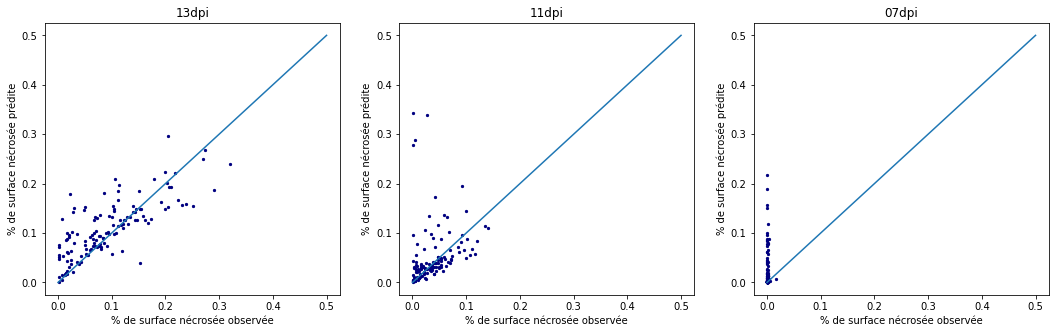

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(131); plt.scatter(df_GT[df_GT['time']=='13dpi']['surface'], df_GMM[df_GMM['time']=='13dpi']['surface'], s=5, c='navy');
plt.plot([0.0, 0.5], [0, 0.5]);plt.title('13dpi');plt.xlabel("% de surface nécrosée observée");plt.ylabel("% de surface nécrosée prédite")
plt.subplot(132); plt.scatter(df_GT[df_GT['time']=='11dpi']['surface'], df_GMM[df_GMM['time']=='11dpi']['surface'], s=5, c='navy');
plt.plot([0.0, 0.5], [0, 0.5]);plt.title('11dpi');plt.xlabel("% de surface nécrosée observée");plt.ylabel("% de surface nécrosée prédite")
plt.subplot(133); plt.scatter(df_GT[df_GT['time']=='07dpi']['surface'], df_GMM[df_GMM['time']=='07dpi']['surface'], s=5, c='navy');
plt.plot([0.0, 0.5], [0, 0.5]);plt.title('07dpi');plt.xlabel("% de surface nécrosée observée");plt.ylabel("% de surface nécrosée prédite")
plt.savefig('comp_Gmm2.png')

In [ ]:
df_GMM.to_csv(index=False)

'fond,feuille,necrose,surface\n82161,125121,32718,0.018216561000000003\n101489,117873,20638,0.039298481\n92968,128447,18585,0.110045956\n74005,102280,63715,0.000138166\n109985,83450,46565,0.007883948\n113047,112014,14939,0.116715891\n95681,118192,26127,0.038304596\n15999,130043,93958,0.071718057\n134400,85075,20525,0.133417593\n135033,96059,8908,0.188223495\n117228,97426,25346,0.338737699\n109551,103244,27205,0.079079003\n122397,106953,10650,0.157374975\n78140,107770,54090,0.028656525\n116131,106271,17598,0.038142742\n136046,101504,2450,0.01664332\n129534,93576,16890,0.34196706\n127670,91059,21271,0.054012171\n133129,104952,1919,0.015771703\n126484,104289,9227,0.288443195\n112200,110464,17336,0.128889815\n132356,92347,15297,0.00090927\n129264,94584,16152,0.01304746\n141841,95491,2668,0.018462518\n128201,106644,5155,0.008229710999999999\n91791,108114,40095,0.001729364\n121939,101628,16433,0.0012758280000000001\n186588,49821,3591,0.0024652470000000003\n189886,46822,3292,0.007620085\n1857

In [ ]:
df_GT.to_csv(index=False)

'fond,feuille,necrose,surface\n123872,116128,0.0,0.0\n122856,112101,5043.0,0.04304958000409752\n127139,99308,13553.0,0.12008576922054563\n100947,138988,65.0,0.00046744766384040616\n108630,127964,3406.0,0.025926771713481008\n110748,114189,15063.0,0.11653978274997678\n116431,123530,39.0,0.000315613139217765\n128792,106460,4748.0,0.042694770160420115\n132785,96349,10866.0,0.10134775917548851\n94727,145214,59.0,0.00040613190338190856\n104056,132254,3690.0,0.027143529688695347\n107563,123641,8796.0,0.06641648481919706\n105889,134031,80.0,0.0005965207924778728\n106346,133191,463.0,0.0034641686743382165\n104952,131680,3368.0,0.024939280848290977\n100153,139797,50.0,0.00035753359028080687\n100082,139686,232.0,0.0016581140382223873\n97625,140923,1452.0,0.010198419666374012\n103677,135953,370.0,0.002714142147693346\n109717,129578,705.0,0.005411296945879355\n109567,129486,947.0,0.0072604325592449765\n91172,148675,153.0,0.0010280323595022443\n93457,144280,2263.0,0.015442566345714228\n93679,144060,

# **Images to print**

In [ ]:
path_GT = '/content/drive/MyDrive/Images/GT/GT_2021_Lydia/Qui_oNzT4_p1c2_13dpi.L.mac.png'
path_ROI = '/content/drive/MyDrive/Images/ROI/ROI_Lydia/Qui_oNzT4_p1c2_13dpi.L.ROI.jpg'
img_ROI = reduire(zoom_ROI(io.imread(path_ROI)))
img_GT = reduire(zoom_ROI(io.imread(path_GT)))

In [ ]:
def histogramOpenCV(_img):
   rgbcolors = ['red', 'green', 'blue']
   for i,col in enumerate(rgbcolors):
     histr = cv.calcHist([_img],[i],None,[256],[0,256])
     plt.plot(histr[1:len(histr)-1],color = col)

In [ ]:
path_ROI_2 = path_ROI.replace('13dpi', '11dpi')
path_ROI_3 = path_ROI.replace('13dpi', '07dpi')

img_ROI_2 = reduire(zoom_ROI(io.imread(path_ROI_2)))
img_ROI_3 = reduire(zoom_ROI(io.imread(path_ROI_3)))

In [ ]:
path_GT_2 = path_GT.replace('13dpi', '11dpi')
path_GT_3 = path_GT.replace('13dpi', '07dpi')

img_GT_2 = reduire(zoom_ROI(io.imread(path_GT_2)))
img_GT_3 = reduire(zoom_ROI(io.imread(path_GT_3)))

## **Histogramme**

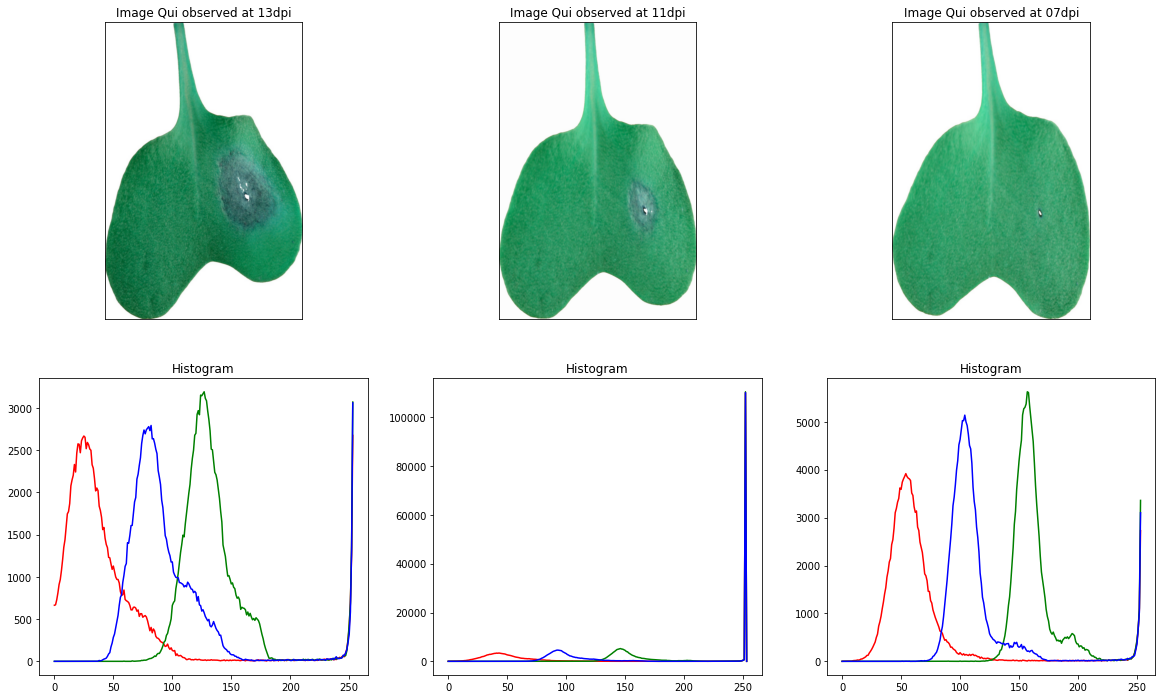

In [ ]:
plt.figure(figsize=(20, 12))
plt.subplot(231);plt.imshow(img_ROI);plt.title('Image Qui observed at 13dpi');plt.xticks([]), plt.yticks([]);
plt.subplot(232);plt.imshow(img_ROI_2);plt.title('Image Qui observed at 11dpi');plt.xticks([]), plt.yticks([]);
plt.subplot(233);plt.imshow(img_ROI_3);plt.title('Image Qui observed at 07dpi');plt.xticks([]), plt.yticks([]);
plt.subplot(234);histogramOpenCV(img_ROI);plt.title('Histogram');#plt.xticks([]), plt.yticks([]);
plt.subplot(235);histogramOpenCV(img_ROI_2);plt.title('Histogram');#plt.xticks([]), plt.yticks([]);
plt.subplot(236);histogramOpenCV(img_ROI_3);plt.title('Histogram');#plt.xticks([]), plt.yticks([]);
plt.savefig('img_Qui_1.png')

## **GMM Clustering**

In [ ]:
def gmm_img2(img1, img2, img3):

  gmm = GaussianMixture(n_components = 3, covariance_type = "tied", tol = 1e-4)
  gmm_img1 = gmm.fit(img1.reshape(img1.shape[0]*img1.shape[1],3))
  #gmm_img2 = gmm.fit(img2.reshape(img1.shape[0]*img1.shape[1],3))
  #gmm_img3 = gmm.fit(img3.reshape(img1.shape[0]*img1.shape[1],3))
  kernel = np.ones((10,10), dtype='uint8')


  cluster_img1 = gmm_img1.predict(img1.reshape(img1.shape[0]*img1.shape[1],3))
  cluster_img1 = cluster_img1.reshape(img1.shape[0], img1.shape[1])
  img_closed1 = cv.morphologyEx(np.uint8(cluster_img1), cv.MORPH_CLOSE, kernel)

  cluster_img2 = gmm_img1.predict(img2.reshape(img2.shape[0]*img2.shape[1],3))
  cluster_img2 = cluster_img2.reshape(img2.shape[0], img2.shape[1])
  img_closed2 = cv.morphologyEx(np.uint8(cluster_img2), cv.MORPH_CLOSE, kernel)

  cluster_img3 = gmm_img1.predict(img3.reshape(img3.shape[0]*img3.shape[1],3))
  cluster_img3 = cluster_img3.reshape(img3.shape[0], img3.shape[1])
  img_closed3 = cv.morphologyEx(np.uint8(cluster_img3), cv.MORPH_CLOSE, kernel)
  
  return cluster_img1, img_closed1, cluster_img2, img_closed2, cluster_img3, img_closed3

In [ ]:
cluster_img1, img_closed1, cluster_img2, img_closed2, cluster_img3, img_closed3 = gmm_img2(img1 = img_ROI, img2 = img_ROI_2, img3 = img_ROI_3)

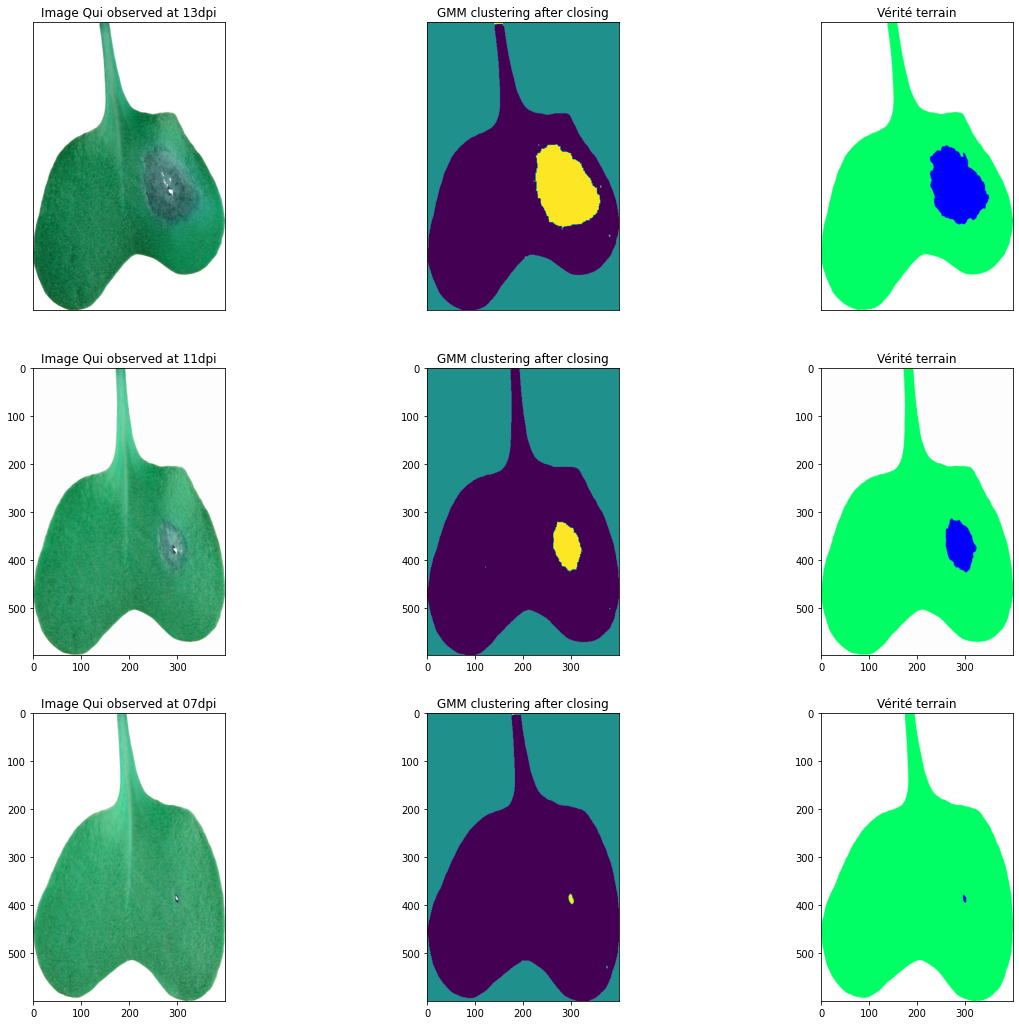

In [ ]:
plt.figure(figsize=(20, 18))
plt.subplot(331);plt.imshow(img_ROI);plt.title('Image Qui observed at 13dpi');plt.xticks([]), plt.yticks([]);
plt.subplot(332);plt.imshow(img_closed1);plt.title('GMM clustering after closing');plt.xticks([]), plt.yticks([]);
plt.subplot(333);plt.imshow(img_GT);plt.title('Vérité terrain');plt.xticks([]), plt.yticks([]);
plt.subplot(334);plt.imshow(img_ROI_2);plt.title('Image Qui observed at 11dpi');#plt.xticks([]), plt.yticks([]);
plt.subplot(335);plt.imshow(img_closed2);plt.title('GMM clustering after closing');#plt.xticks([]), plt.yticks([]);
plt.subplot(336);plt.imshow(img_GT_2);plt.title('Vérité terrain');#plt.xticks([]), plt.yticks([]);
plt.subplot(337);plt.imshow(img_ROI_3);plt.title('Image Qui observed at 07dpi');#plt.xticks([]), plt.yticks([]);
plt.subplot(338);plt.imshow(img_closed3);plt.title('GMM clustering after closing');#plt.xticks([]), plt.yticks([]);
plt.subplot(339);plt.imshow(img_GT_3);plt.title('Vérité terrain');#plt.xticks([]), plt.yticks([]);
plt.savefig('img_Qui_2.png')

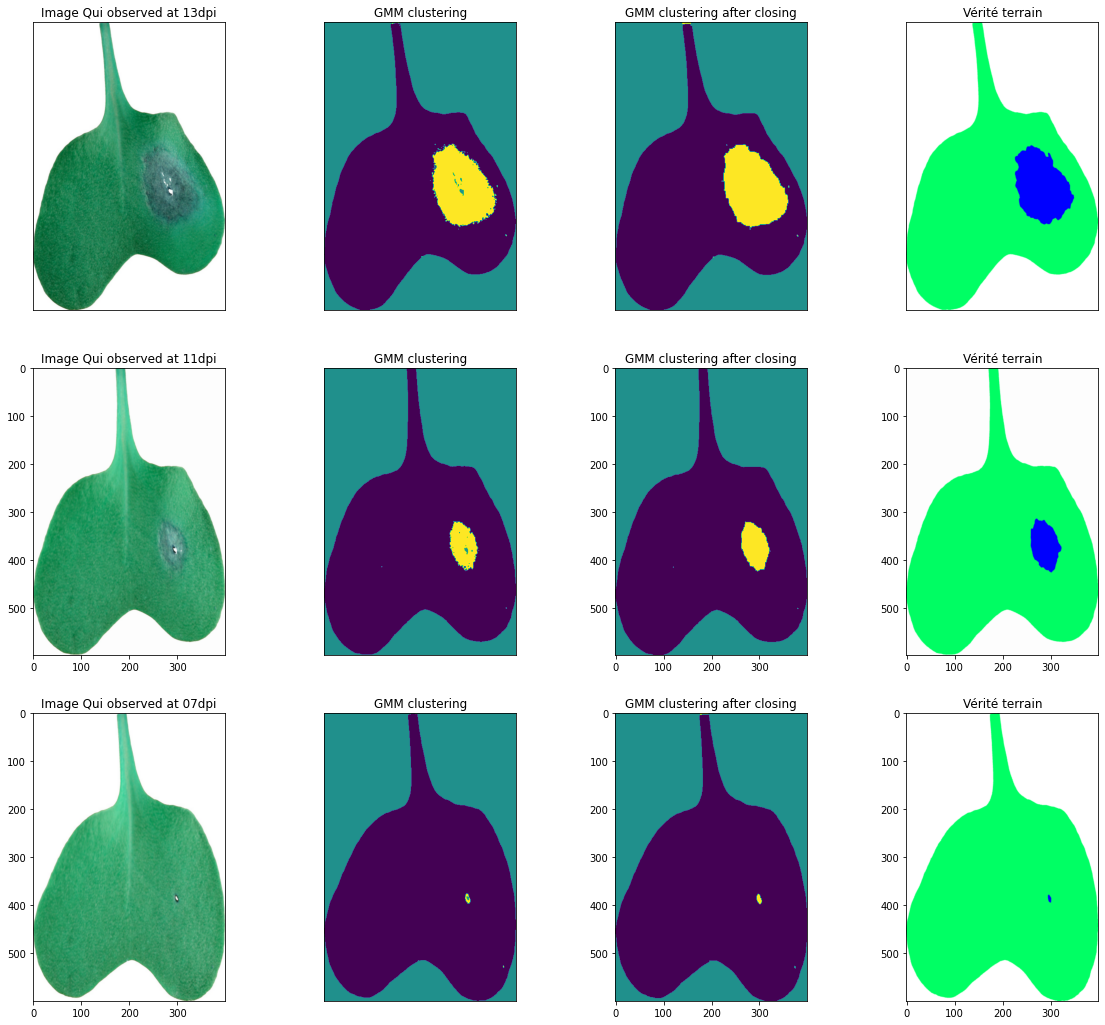

In [ ]:
plt.figure(figsize=(20, 18))
plt.subplot(341);plt.imshow(img_ROI);plt.title('Image Qui observed at 13dpi');plt.xticks([]), plt.yticks([]);
plt.subplot(342);plt.imshow(cluster_img1);plt.title('GMM clustering');plt.xticks([]), plt.yticks([]);
plt.subplot(343);plt.imshow(img_closed1);plt.title('GMM clustering after closing');plt.xticks([]), plt.yticks([]);
plt.subplot(344);plt.imshow(img_GT);plt.title('Vérité terrain');plt.xticks([]), plt.yticks([]);
plt.subplot(345);plt.imshow(img_ROI_2);plt.title('Image Qui observed at 11dpi');#plt.xticks([]), plt.yticks([]);
plt.subplot(346);plt.imshow(cluster_img2);plt.title('GMM clustering');plt.xticks([]), plt.yticks([]);
plt.subplot(347);plt.imshow(img_closed2);plt.title('GMM clustering after closing');#plt.xticks([]), plt.yticks([]);
plt.subplot(348);plt.imshow(img_GT_2);plt.title('Vérité terrain');#plt.xticks([]), plt.yticks([]);
plt.subplot(349);plt.imshow(img_ROI_3);plt.title('Image Qui observed at 07dpi');#plt.xticks([]), plt.yticks([]);
plt.subplot(3,4,10);plt.imshow(cluster_img3);plt.title('GMM clustering');plt.xticks([]), plt.yticks([]);
plt.subplot(3,4,11);plt.imshow(img_closed3);plt.title('GMM clustering after closing');#plt.xticks([]), plt.yticks([]);
plt.subplot(3,4,12);plt.imshow(img_GT_3);plt.title('Vérité terrain');#plt.xticks([]), plt.yticks([]);
plt.savefig('img_Qui_3.png')

## **Surface nécrosée**

In [ ]:
def necrose(cluster_img, img_closed, img_GT):
  # GMM before closing
  label_count_1 = Counter(cluster_img.reshape(-1))
  label_count_1 = sorted(label_count_1.values())
  prop_1 = label_count_1[0]/(label_count_1[0] + label_count_1[1])

  # GMM after closing
  label_count_2 = Counter(img_closed.reshape(-1))
  label_count_2 = sorted(label_count_2.values())
  prop_2 = label_count_2[0]/(label_count_2[0] + label_count_2[1])

  # GMM after closing
  label_count_3 = Counter(img_GT.reshape(-1))
  label_count_3 = sorted(label_count_3.values())
  prop_3 = label_count_3[0]/(label_count_3[0] + label_count_3[1])

  return prop_1, label_count_1, prop_2, label_count_2, prop_3, label_count_3

In [ ]:
img_GT_lbl = img_to_label(img_GT)
img_GT_lbl_2 = img_to_label(img_GT_2)
img_GT_lbl_3 = img_to_label(img_GT_3)

In [ ]:
imgs_cluster = [cluster_img1, cluster_img2, cluster_img3]
imgs_closed = [img_closed1, img_closed2, img_closed3]
imgs_GT = [img_GT_lbl, img_GT_lbl_2, img_GT_lbl_3]

prop_clust = []
label_clust = []
prop_clos = []
label_clos = []
prop_GT = []
label_GT = []

for i in range(3):
  Nec = necrose(cluster_img=imgs_cluster[i], img_closed=imgs_closed[i], img_GT=imgs_GT[i])
  prop_clust.append(Nec[0])
  label_clust.append(Nec[1])
  prop_clos.append(Nec[2])
  label_clos.append(Nec[3])
  prop_GT.append(Nec[4])
  label_GT.append(Nec[5])


### **En proportion**

In [ ]:
print(f" 13dpi \t avant closing : {round(prop_clust[0],3)}\t après closing : {round(prop_clos[0],3)}\t Vraie proportion : {round(prop_GT[0],3)} \n 11dpi \t avant closing : {round(prop_clust[1],3)}\t après closing : {round(prop_clos[1],3)}\t Vraie proportion : {round(prop_GT[1],3)} \n 07dpi \t avant closing : {round(prop_clust[2],3)}\t après closing : {round(prop_clos[2],3)}\t Vraie proportion : {round(prop_GT[2],3)}")

 13dpi 	 avant closing : 0.129	 après closing : 0.136	 Vraie proportion : 0.111 
 11dpi 	 avant closing : 0.035	 après closing : 0.036	 Vraie proportion : 0.041 
 07dpi 	 avant closing : 0.001	 après closing : 0.002	 Vraie proportion : 0.001


### **En nombre de pixels**

In [ ]:
print(f" 13dpi \t avant closing : {round(label_clust[0][0],0)}\t après closing : {round(label_clos[0][0],0)}\t Vraie : {round(label_GT[0][0],0)} \n 11dpi \t avant closing : {round(label_clust[1][0],0)}\t après closing : {round(label_clos[1][0],0)}\t Vraie : {round(label_GT[1][0],0)} \n 07dpi \t avant closing : {round(label_clust[2][0],0)}\t après closing : {round(label_clos[2][0],0)}\t Vraie : {round(label_GT[2][0],0)}")

 13dpi 	 avant closing : 15519	 après closing : 16379	 Vraie : 13561 
 11dpi 	 avant closing : 4065	 après closing : 4263	 Vraie : 4835 
 07dpi 	 avant closing : 153	 après closing : 228	 Vraie : 80


### **Matrice de confusion sur les pixels**

In [ ]:
# 13dpi
y_actu = pd.Series(img_GT_lbl.ravel(), name='Actual')
y_pred = pd.Series(img_closed1.ravel(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, margins=True)
df_confusion

Predicted,0,1,2,All
Actual,,,,
0.0,103754,1570,2863,108187
1.0,250,117990,12,118252
2.0,57,0,13504,13561
All,104061,119560,16379,240000


In [ ]:
# 11dpi
y_actu = pd.Series(img_GT_lbl_2.ravel(), name='Actual')
y_pred = pd.Series(img_closed2.ravel(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, margins=True)
df_confusion

Predicted,0,1,2,All
Actual,,,,
0.0,121612,1661,79,123352
1.0,144,111669,0,111813
2.0,651,0,4184,4835
All,122407,113330,4263,240000


In [ ]:
# 07dpi
y_actu = pd.Series(img_GT_lbl_3.ravel(), name='Actual')
y_pred = pd.Series(img_closed3.ravel(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1,2
Actual,,,
0.0,134409,1696,148
1.0,135,103532,0
2.0,0,0,80


### **Erreur de précision sur l'ensemble des images**

In [ ]:
eps = []
for i in range(len(closed_imgs)):
  y_actu = pd.Series(img_to_label(images_GT[i]).ravel(), name='Actual')
  y_pred = pd.Series(closed_imgs[i].ravel(), name='Predicted')
  eps.append(accuracy_score(y_actu, y_pred))

mean(eps)

0.8886544958847736

### **Erreur quadratique moyenne sur l'ensemble des images**

In [ ]:
mean(np.array(df_GMM['surface']) - np.array(df_GT['surface'])**2)

0.05429213000106856